In [4]:
%matplotlib inline


# Additive function

We use an elementary example to intuitively convey the sensitivities according to 
different metrics.

\begin{align}f(x) = a \cdot X_1 + b \cdot X_2, \quad X_1, X_2 \sim \mathcal{N}(0, 1), \quad a,b \in \mathbb{R}\end{align}

In the plot below, we note that the indices provide different sensitivities for the two 
inputs. The variance-based Sobol indices use variance as a metric to quantify 
sensitivity, whereas the Chatterjee/Cramér-von Mises indices use the entire probability 
distribution function (PDF) to quantify the sensitivity. In general, moment-free indices 
provide a more holistic measure of sensitivity unlike the variance-based indices, which 
are accurate mainly when the output distribution close to a Gaussian (see [1]_ for a
motivating example).   

.. [1] Borgonovo, E. (2006). Measuring uncertainty importance: Investigation and comparison of alternative approaches. Risk Analysis, 26(5), 1349-1361.


In [5]:
import numpy as np
import matplotlib.pyplot as plt

from UQpy.run_model.RunModel import RunModel
from UQpy.run_model.model_execution.PythonModel import PythonModel
from UQpy.distributions import Normal
from UQpy.distributions.collection.JointIndependent import JointIndependent
from UQpy.sensitivity.ChatterjeeSensitivity import ChatterjeeSensitivity
from UQpy.sensitivity.CramerVonMisesSensitivity import CramerVonMisesSensitivity as cvm
from UQpy.sensitivity.SobolSensitivity import SobolSensitivity
from UQpy.sensitivity.PostProcess import *

np.random.seed(123)

**Define the model and input distributions**



In [6]:
# Create Model object
a, b = 1, 2

model = PythonModel(
    model_script="local_additive.py",
    model_object_name="evaluate",
    var_names=[
        "X_1",
        "X_2",
    ],
    delete_files=True,
    params=[a, b],
)

runmodel_obj = RunModel(model=model)

# Define distribution object
dist_object = JointIndependent([Normal(0, 1)] * 2)

**Compute Sobol indices**



In [7]:
SA_sobol = SobolSensitivity(runmodel_obj, dist_object)

SA_sobol.run(n_samples=50_000)

**First order Sobol indices**

Expected first order Sobol indices:

$\mathrm{S}_1 = \frac{a^2 \cdot \mathbb{V}[X_1]}{a^2 \cdot \mathbb{V}[X_1] + b^2 \cdot \mathbb{V}[X_2]} = \frac{1^2 \cdot 1}{1^2 \cdot 1 + 2^2 \cdot 1} = 0.2$

$\mathrm{S}_2 = \frac{b^2 \cdot \mathbb{V}[X_2]}{a^2 \cdot \mathbb{V}[X_1] + b^2 \cdot \mathbb{V}[X_2]} = \frac{2^2 \cdot 1}{1^2 \cdot 1 + 2^2 \cdot 1} = 0.8$



In [8]:
SA_sobol.first_order_indices

array([[0.19403013],
       [0.80059683]])

**Compute Chatterjee indices**



In [9]:
SA_chatterjee = ChatterjeeSensitivity(runmodel_obj, dist_object)

SA_chatterjee.run(n_samples=50_000)

In [10]:
SA_chatterjee.first_order_chatterjee_indices

array([[0.11439943],
       [0.56937622]])

In [11]:
SA_cvm = cvm(runmodel_obj, dist_object)

# Compute CVM indices using the pick and freeze algorithm
SA_cvm.run(n_samples=20_000, estimate_sobol_indices=True)

In [12]:
SA_cvm.first_order_CramerVonMises_indices

array([[0.10696542],
       [0.57198283]])

**Plot all indices**



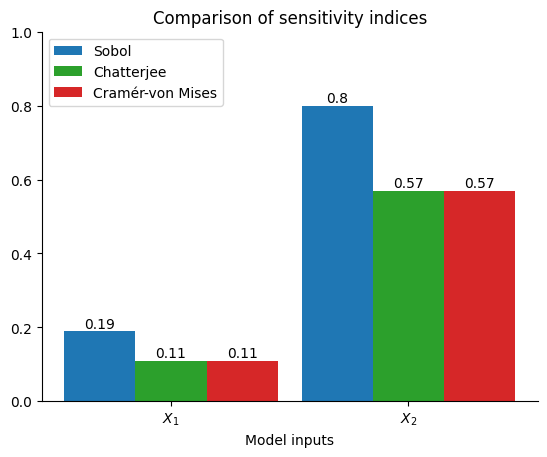

In [13]:
num_vars = 2
_idx = np.arange(num_vars)
variable_names = [r"$X_{}$".format(i + 1) for i in range(num_vars)]

# round to 2 decimal places
indices_1 = np.around(SA_sobol.first_order_indices[:, 0], decimals=2)
indices_2 = np.around(SA_chatterjee.first_order_chatterjee_indices[:, 0], decimals=2)
indices_3 = np.around(SA_cvm.first_order_CramerVonMises_indices[:, 0], decimals=2)

fig, ax = plt.subplots()
width = 0.3
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

bar_indices_1 = ax.bar(
    _idx - width,  # x-axis
    indices_1,  # y-axis
    width=width,  # bar width
    color="C0",  # bar color
    # alpha=0.5,  # bar transparency
    label="Sobol",  # bar label
    ecolor="k",  # error bar color
    capsize=5,  # error bar cap size in pt
)

bar_indices_2 = ax.bar(
    _idx,  # x-axis
    indices_2,  # y-axis
    width=width,  # bar width
    color="C2",  # bar color
    # alpha=0.5,  # bar transparency
    label="Chatterjee",  # bar label
    ecolor="k",  # error bar color
    capsize=5,  # error bar cap size in pt
)

bar_indices_3 = ax.bar(
    _idx + width,  # x-axis
    indices_3,  # y-axis
    width=width,  # bar width
    color="C3",  # bar color
    # alpha=0.5,  # bar transparency
    label="Cramér-von Mises",  # bar label
    ecolor="k",  # error bar color
    capsize=5,  # error bar cap size in pt
)

ax.bar_label(bar_indices_1, label_type="edge", fontsize=10)
ax.bar_label(bar_indices_2, label_type="edge", fontsize=10)
ax.bar_label(bar_indices_3, label_type="edge", fontsize=10)
ax.set_xticks(_idx, variable_names)
ax.set_xlabel("Model inputs")
ax.set_title("Comparison of sensitivity indices")
ax.set_ylim(top=1)  # set only upper limit of y to 1
ax.legend()

plt.show()